# End To End Demo

This notebooks demonstrates the data flow of generating a graph from a CSV file using Runway v0.9.0

In [1]:
import os

import pandas as pd
from dotenv import load_dotenv

from neo4j_runway import Discovery, GraphDataModeler, PyIngest, UserInput
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.utils import test_database_connection

load_dotenv()

True

## Load and Describe Data

The USER_GENERATED_INPUT variable contains a general discription and feature descriptions for each feature we'd like to use in our graph.

In [2]:
USER_GENERATED_INPUT = UserInput(general_description='This is data on different countries.',
                                 column_descriptions={
                                     'id': 'unique id for a country.',
                                    'name': 'the country name.',
                                    'phone_code': 'country area code.',
                                    'capital': 'the capital of the country.',
                                    'currency_name': "name of the country's currency.",
                                    'region': 'primary region of the country.',
                                    'subregion': 'subregion location of the country.',
                                    'timezones': 'timezones contained within the country borders.',
                                    'latitude': 'the latitude coordinate of the country center.',
                                    'longitude': 'the longitude coordinate of the country center.'
                                    },
                                use_cases=[
        "Which region contains the most subregions?", 
        "What currencies are most popular?", 
        "Which countries share timezones?"
    ]  
                                )

In [4]:
data = pd.read_csv("../../data/countries/countries.csv")

In [5]:
data.head()

,id,name,iso3,iso2,numeric_code,phone_code,capital,currency,currency_name,currency_symbol,tld,native,region,subregion,timezones,latitude,longitude,emoji,emojiU
0,1,Afghanistan,AFG,AF,4,93,Kabul,AFN,Afghan afghani,؋,.af,افغانستان,Asia,Southern Asia,"[{zoneName:'Asia\/Kabul',gmtOffset:16200,gmtOf...",33.000000,65.0,🇦🇫,U+1F1E6 U+1F1EB
1,2,Aland Islands,ALA,AX,248,+358-18,Mariehamn,EUR,Euro,€,.ax,Åland,Europe,Northern Europe,"[{zoneName:'Europe\/Mariehamn',gmtOffset:7200,...",60.116667,19.9,🇦🇽,U+1F1E6 U+1F1FD
2,3,Albania,ALB,AL,8,355,Tirana,ALL,Albanian lek,Lek,.al,Shqipëria,Europe,Southern Europe,"[{zoneName:'Europe\/Tirane',gmtOffset:3600,gmt...",41.000000,20.0,🇦🇱,U+1F1E6 U+1F1F1
3,4,Algeria,DZA,DZ,12,213,Algiers,DZD,Algerian dinar,دج,.dz,الجزائر,Africa,Northern Africa,"[{zoneName:'Africa\/Algiers',gmtOffset:3600,gm...",28.000000,3.0,🇩🇿,U+1F1E9 U+1F1FF
4,5,American Samoa,ASM,AS,16,+1-684,Pago Pago,USD,US Dollar,$,.as,American Samoa,Oceania,Polynesia,"[{zoneName:'Pacific\/Pago_Pago',gmtOffset:-396...",-14.333333,-170.0,🇦🇸,U+1F1E6 U+1F1F8


## Initialize LLMs

We now initialize the LLMs to use in data discovery and data model creation.

In [6]:
llm_disc = OpenAIDiscoveryLLM(model_name='gpt-4o-mini-2024-07-18', model_params={"temperature": 0})
llm_dm = OpenAIDataModelingLLM(model_name='gpt-4o-2024-05-13', model_params={"temperature": 0.5})

## Discovery

We now load the above data into a Discovery object.

In [7]:
disc = Discovery(llm=llm_disc, user_input=USER_GENERATED_INPUT, data=data)

In [8]:
disc.run(show_result=True, notebook=True)

### Preliminary Analysis of Country Data

#### Overall Characteristics:
1. **Data Structure**: The dataset contains 250 entries (countries) and 10 features. The features include both categorical (e.g., name, capital, currency_name) and numerical (e.g., latitude, longitude) data types.
2. **Missing Values**: There are some missing values in the `capital` (5), `region` (2), and `subregion` (3) columns. This indicates that not all countries have a specified capital or belong to a defined region/subregion.
3. **Memory Usage**: The dataset is relatively small, with a memory usage of approximately 19.7 KB.

#### Feature Analysis:
1. **ID**: 
   - Unique identifier for each country.
   - The distribution is uniform, ranging from 1 to 250.

2. **Name**: 
   - Each country has a unique name, with a total of 250 unique entries.
   - This feature is crucial for identifying countries.

3. **Phone Code**: 
   - There are 235 unique phone codes, indicating that some countries share the same code.
   - The most common phone code is '1', which is used by multiple countries.

4. **Capital**: 
   - 245 out of 250 entries have a specified capital.
   - The most frequently occurring capital is Kingston, which is the capital of two countries.

5. **Currency Name**: 
   - There are 161 unique currency names, with the Euro being the most common (35 occurrences).
   - This feature is important for economic analysis and understanding trade relationships.

6. **Region**: 
   - The dataset includes 6 unique regions, with Africa being the most represented (60 countries).
   - This feature is significant for geographical and socio-economic studies.

7. **Subregion**: 
   - There are 22 unique subregions, with the Caribbean being the most common (28 occurrences).
   - This feature can help in understanding cultural and economic similarities among countries.

8. **Timezones**: 
   - The `timezones` feature contains 245 unique entries, indicating that some countries have multiple time zones.
   - This feature is important for understanding international relations and scheduling.

9. **Latitude and Longitude**: 
   - Latitude ranges from -74.65 to 78, while longitude ranges from -176.2 to 178.
   - These features are essential for geographical mapping and spatial analysis.

#### Important Features:
- **Name**: Essential for identifying countries.
- **Phone Code**: Important for telecommunications and international dialing.
- **Capital**: Key for political and administrative analysis.
- **Currency Name**: Crucial for economic relationships and trade.
- **Region and Subregion**: Important for geographical and cultural studies.
- **Latitude and Longitude**: Necessary for geographical mapping and analysis.

### Conclusion:
The dataset provides a comprehensive overview of various countries, with important features that can be utilized for geographical, economic, and political analyses. The presence of missing values in certain features should be addressed, especially for capital, region, and subregion, to ensure a complete understanding of the dataset.

## Data Modeling

We can now use our Discovery object to provide context to the LLM for data model generation. We don't *need* the discovery information for this step to work, but it provides much better models.

In [9]:
gdm = GraphDataModeler(
    llm=llm_dm,
    discovery=disc
)

We now generate our first pass data model.

In [10]:
gdm.create_initial_model(max_retries=2)

Entity Pool Generation Attempt: 1

 Please generate a pool of entities that will be used to construct a graph data model. Here are the initial discovery findings:
### Preliminary Analysis of Country Data

#### Overall Characteristics:
1. **Data Structure**: The dataset contains 250 entries (countries) and 10 features. The features include both categorical (e.g., name, capital, currency_name) and numerical (e.g., latitude, longitude) data types.
2. **Missing Values**: There are some missing values in the `capital` (5), `region` (2), and `subregion` (3) columns. This indicates that not all countries have a specified capital or belong to a defined region/subregion.
3. **Memory Usage**: The dataset is relatively small, with a memory usage of approximately 19.7 KB.

#### Feature Analysis:
1. **ID**: 
   - Unique identifier for each country.
   - The distribution is uniform, ranging from 1 to 250.

2. **Name**: 
   - Each country has a unique name, with a total of 250 unique entries.
   - Th

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', column_mapping='phone_code', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', column_mapping='latitude', alias=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', column_mapping='longitude', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='Region', properties=[Property(name='region', type='str', column_mapping='region', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Subregion', properties=[Property(name='subregion', type='str', column_mapping='su

In [11]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', column_mapping='phone_code', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', column_mapping='latitude', alias=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', column_mapping='longitude', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='Region', properties=[Property(name='region', type='str', column_mapping='region', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Subregion', properties=[Property(name='subregion', type='str', column_mapping='su

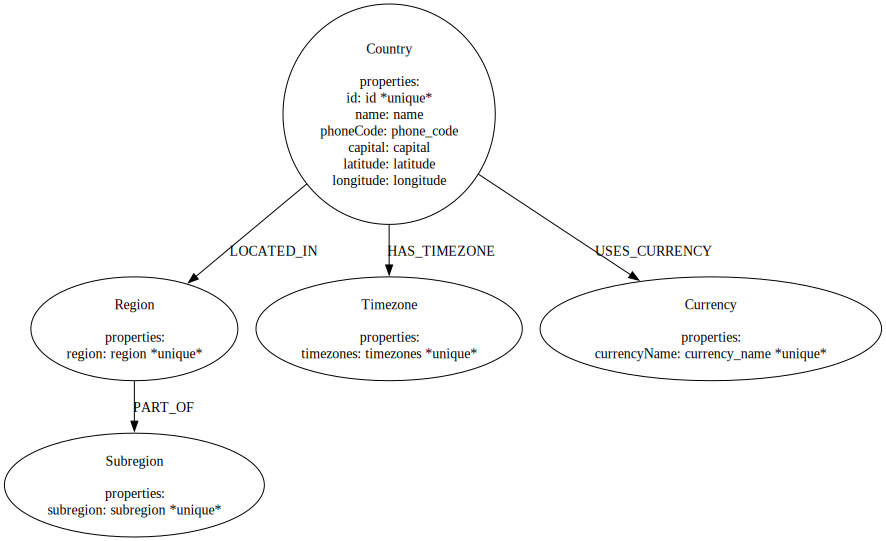

In [13]:
gdm.current_model.visualize()

We can clean this up a bit, so let's prompt the LLM to make some corrections.

In [15]:
gdm.iterate_model(corrections="""Flip the Region and Subregion nodes""")


 Please make corrections to the graph data model using the context provided. Here are the initial discovery findings:
### Preliminary Analysis of Country Data

#### Overall Characteristics:
1. **Data Structure**: The dataset contains 250 entries (countries) and 10 features. The features include both categorical (e.g., name, capital, currency_name) and numerical (e.g., latitude, longitude) data types.
2. **Missing Values**: There are some missing values in the `capital` (5), `region` (2), and `subregion` (3) columns. This indicates that not all countries have a specified capital or belong to a defined region/subregion.
3. **Memory Usage**: The dataset is relatively small, with a memory usage of approximately 19.7 KB.

#### Feature Analysis:
1. **ID**: 
   - Unique identifier for each country.
   - The distribution is uniform, ranging from 1 to 250.

2. **Name**: 
   - Each country has a unique name, with a total of 250 unique entries.
   - This feature is crucial for identifying countr

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', column_mapping='phone_code', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', column_mapping='latitude', alias=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', column_mapping='longitude', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='Region', properties=[Property(name='region', type='str', column_mapping='region', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Subregion', properties=[Property(name='subregion', type='str', column_mapping='su

In [16]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', column_mapping='phone_code', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', column_mapping='latitude', alias=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', column_mapping='longitude', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='Region', properties=[Property(name='region', type='str', column_mapping='region', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Subregion', properties=[Property(name='subregion', type='str', column_mapping='su

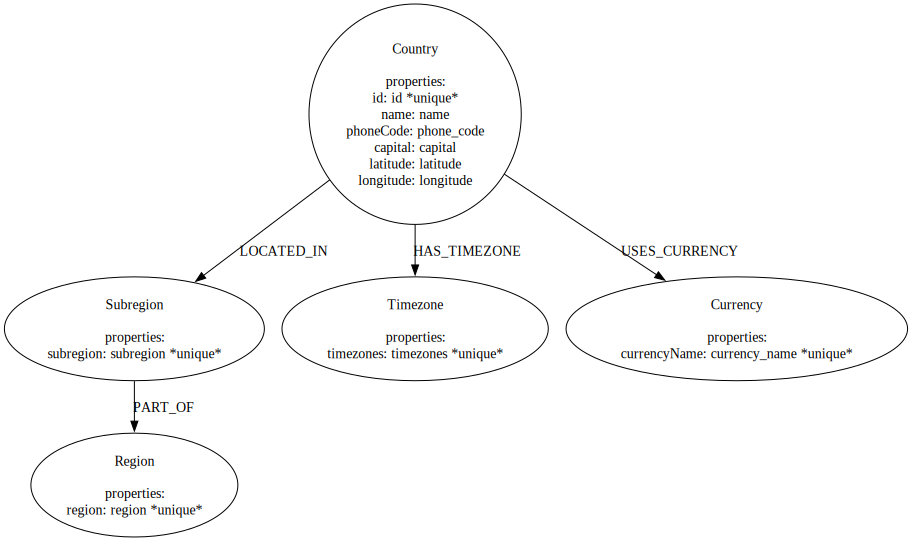

In [17]:
gdm.current_model.visualize()

We can now create some ingestion code to get our data into our database.

## Ingestion Code Generation

We can provide our credentials here in this step if we plan on using PyIngest to load our data. This will inject our credentials into the generated YAML file. If we leave the credential fields blank, then we can just fill in the blanks in the generated YAML file later.

In [18]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, 
                         username=os.environ.get("NEO4J_USERNAME"), 
                         password=os.environ.get("NEO4J_PASSWORD"), 
                         uri=os.environ.get("NEO4J_URI"), 
                         database=os.environ.get("NEO4J_DATABASE"), 
                         file_directory="data/csv/", source_name="countries.csv")

In [19]:
pyingest_yaml = gen.generate_config_string()
print(pyingest_yaml)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
database: neo4j
basepath: ./

pre_ingest:
  - CREATE CONSTRAINT country_id IF NOT EXISTS FOR (n:Country) REQUIRE n.id IS UNIQUE;
  - CREATE CONSTRAINT region_region IF NOT EXISTS FOR (n:Region) REQUIRE n.region IS UNIQUE;
  - CREATE CONSTRAINT subregion_subregion IF NOT EXISTS FOR (n:Subregion) REQUIRE n.subregion IS UNIQUE;
  - CREATE CONSTRAINT timezone_timezones IF NOT EXISTS FOR (n:Timezone) REQUIRE n.timezones IS UNIQUE;
  - CREATE CONSTRAINT currency_currencyname IF NOT EXISTS FOR (n:Currency) REQUIRE n.currencyName IS UNIQUE;
files:
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:Country {id: toIntegerOrNull(row.id)})
    SET n.name = row.name, n.phoneCode = row.phone_code, n.capital = row.capital, n.latitude = toFloatOrNull(row.latitude), n.longitude = toFloatOrNull(row.longitude)
  url: $BASE/data/csv/countries.csv
- chunk_size: 100
  cql: |
    WITH $dict.rows 

## Ingest Data

We can use the generated yaml string above to orchestrate the data loading via a modified PyIngest function. First let's confirm our connection though.

In [20]:
test_database_connection(credentials={"username": os.environ.get("NEO4J_USERNAME"), "password": os.environ.get("NEO4J_PASSWORD"), "uri": os.environ.get("NEO4J_URI")})

{'valid': True, 'message': 'Connection and Auth Verified!'}

In [21]:
PyIngest(config=pyingest_yaml, dataframe=data)

File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.049717
loading... 1 2024-08-28 09:10:40.186946
{} : Completed file 2024-08-28 09:10:40.220505
File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.221087
loading... 1 2024-08-28 09:10:40.263834
{} : Completed file 2024-08-28 09:10:40.275475
File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.275817
loading... 1 2024-08-28 09:10:40.307399
{} : Completed file 2024-08-28 09:10:40.322197
File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.322525
loading... 1 2024-08-28 09:10:40.367488
{} : Completed file 2024-08-28 09:10:40.404210
File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.404591
loading... 1 2024-08-28 09:10:40.438580
{} : Completed file 2024-08-28 09:10:40.459188
File {} .//data/csv/countries.csv
loading... 0 2024-08-28 09:10:40.459669
loading... 1 2024-08-28 09:10:40.504272
{} : Completed file 2024-08-28 09:10:40.524525
File {} .//data/csv/countries.csv


If we check our database we can see that we've ingested our CSV according to the data model we've created!

![countries-graph-0.9.0.png](../../images/countries-graph-0.9.0.png)